<a href="https://colab.research.google.com/github/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/ML_for_MPPT_prediction_in_PV_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Machine Learning network for a commercial SG340P photovoltaic power prediction using different environmental data of Vitoria-Gasteiz, Spain. **



Explanation of this project can be found in https://www.mdpi.com/1996-1073/14/22/7806

This notebook does the following:

* **Read data from IBM db2 database.** 
* **Load data into dataframes.**
* **Clean & visuolize the data.**
* **Filter the data.**
* **Loading data into Spark DataFrames**
* **Apply statistics.**
* **Training.**

In [1]:
# Installing required packages

!pip install pyspark
!pip install findspark
import findspark
findspark.init()

!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa==0.3.7

     |████████████████████████████████| 281.4 MB 23 kB/s 
     |████████████████████████████████| 198 kB 60.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=4629708e60bf636aa37a5fe59b750a8b238a98557a7652cc7cfb184f4d5e5e10
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 6.0 MB 7.2 MB/s 
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.9-cp37-cp37m-linux_x86_64.whl size=1203580 sha256=7fd087a4e9d761e4436cdf8ed23e5c2568fa9a544afdc222e63b3602afeb16f9
  Stored in directory: /root/.cache/pip/wheels/03/71/13/010faf12246f72dc76b4150e6e599d13a85b4435e06fb9e51f
Successfully built sqlalchemy
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.31
    Uninstalling SQLAlchemy-1.4.31:
      Successfully uninstalled SQLAlchemy-1.4.31
     |████████████████████████████████| 1.1 MB 12.3 MB

In [2]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import models, layers, optimizers
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from google.colab import files
import io

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import LinearRegression

import ibm_db
import ibm_db_sa
import ibm_db_dbi
import sqlalchemy
from sqlalchemy import *

##Connect to the database

### 1) First method

In [3]:
#Replace the placeholder values with your actual Db2 hostname, username, and password:
dsn_hostname = "55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud" # e.g.: "54a2f15b-5c0f-46df-8954-7e38e612c2bd.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud"
dsn_uid = "wzw37676"        # e.g. "abc12345"
dsn_pwd = "RqVbtpgxaho1uE5S"      # e.g. "7dBZ3wWt9XN6$o0J"

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "bludb"            # e.g. "BLUDB"
dsn_port = "31929"                # e.g. "32733" 
dsn_protocol = "TCPIP"            # i.e. "TCPIP"
dsn_security = "ssl"              #i.e. "SSL"

#Create database connection
#DO NOT MODIFY THIS CELL. Just RUN it with Shift + Enter
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};"
    "SECURITY={7};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd,dsn_security)
try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  bludb as user:  wzw37676 on host:  55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud


In [4]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)
#query statement to retrieve all rows in INSTRUCTOR table
data1 = "select * from PV_DATA1"
data2 = "select * from PV_DATA2"
data_max = "select * from PV_DATA_MAX"
#retrieve the query results into a pandas dataframe
df1 = pd.read_sql(data1, pconn)
df2 = pd.read_sql(data2, pconn)
df_max = pd.read_sql(data_max, pconn)

### 2) Second method

In [5]:
# %load_ext sql

# # Enter the connection string for your Db2 on Cloud database instance below
# # %sql ibm_db_sa://my-username:my-password@my-hostname:my-port/my-db-name?security=SSL
# %sql ibm_db_sa://wzw37676:RqVbtpgxaho1uE5S@55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud:31929/bludb?security=SSL 

# # Retrieve list of all tables in the database for db2 schema (username)
# %sql select tabschema, tabname, create_time from syscat.tables where tabschema='WZW37676' and tabname like 'PV%'



# data1= %sql select * from PV_DATA1
# data2= %sql select * from PV_DATA2
# data_max= %sql select * from PV_DATA_MAX 

# #Loading data into a Pandas DataFrame
# df1 = data1.DataFrame()
# df2 = data2.DataFrame()
# df_max = data_max.DataFrame()

#Data cleaning & visualization 

In [133]:
# Joining DataFrames
df = pd.concat([df1, df2], axis=1)
df

,TIME01,T_PV01,G_PV01,I_PV01,V_PV01,P_PV01,TIME02,T_PV02,G_PV02,I_PV02,V_PV02,P_PV02,TIME03,T_PV03,G_PV03,I_PV03,V_PV03,P_PV03,TIME04,T_PV04,G_PV04,I_PV04,V_PV04,P_PV04,TIME05,T_PV05,G_PV05,I_PV05,V_PV05,P_PV05,TIME06,T_PV06,G_PV06,I_PV06,V_PV06,P_PV06,TIME07,T_PV07,G_PV07,I_PV07,V_PV07,P_PV07,TIME08,T_PV08,G_PV08,I_PV08,V_PV08,P_PV08,TIME09,T_PV09,G_PV09,I_PV09,V_PV09,P_PV09,TIME10,T_PV10,G_PV10,I_PV10,V_PV10,P_PV10
0,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,43.175272,11.689595,0.000000,21.334229,499.328613,0.279199,45.448010,12.689026,0.000000,27.697754,577.148438,5.622555,1.414828,7.954948,0.000000,35.172119,656.616211,0.274492,43.590099,11.965145,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,39.234619,643.798828,0.265701,43.073828,11.444738,0.00000,15.430908,108.764648,1.052417,0.991038,1.042986,0.000000,23.349609,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,43.174354,11.650719,0.009992,21.016846,496.032715,0.279199,45.447907,12.689028,0.009992,27.666016,577.148438,5.620805,1.415237,7.954770,0.009992,35.124512,656.799316,0.274967,43.591110,11.986113,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.099992,39.202881,642.883301,0.265629,43.076670,11.442393,0.05000,15.541992,109.863281,1.052579,0.992378,1.044556,0.060000,23.365479,263.122559,2.593142,1.102931,2.860055,0.099984,14.843750,428.466797,4.123289,1.176054,4.849210
2,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,43.173432,11.610313,0.019984,21.397705,500.427246,0.280176,45.448064,12.733464,0.019984,27.650146,577.697754,5.619631,1.415052,7.952073,0.019984,35.108643,656.982422,0.275352,43.591364,12.002962,0.079936,38.774414,673.461914,0.271460,43.282639,11.749488,0.199985,39.187012,643.615723,0.265573,43.073666,11.439213,0.10000,15.668945,111.328125,1.052960,0.991841,1.044369,0.120001,23.349609,262.939453,2.591746,1.102531,2.857481,0.199969,14.843750,429.748535,4.122571,1.177623,4.854835
3,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,43.172642,11.572558,0.029976,21.381836,500.244141,0.281924,45.448992,12.813141,0.029976,27.634277,577.514648,5.619608,1.414555,7.949241,0.029976,35.061035,657.165527,0.275497,43.591145,12.009229,0.119904,38.726807,673.278809,0.271034,43.282376,11.731015,0.299977,39.171143,643.981934,0.266636,43.069540,11.483899,0.15000,15.589600,110.229492,1.052630,0.992586,1.044826,0.180001,23.365479,263.671875,2.591802,1.102105,2.856438,0.299953,14.780273,428.283691,4.123618,1.177599,4.855967
4,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,43.171866,11.540397,0.039968,21.318359,499.694824,0.284206,45.450287,12.917227,0.039968,27.634277,577.697754,5.620630,1.413682,7.945784,0.039968,35.092773,657.897949,0.275387,43.590456,12.004234,0.159872,38.663330,672.729492,0.271834,43.284241,11.766119,0.399969,39.218750,644.531250,0.268770,43.076558,11.577704,0.20000,15.462646,109.130859,1.053653,0.990913,1.044078,0.240001,23.349609,263.122559,2.592639,1.102860,2.859317,0.399938,14.827881,428.649902,4.123088,1.177333,4.854249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15428.73283,12.510986,54.199219,0.541716,0.922258,0.499602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Replace NAN rows by the last recording row *data* for each graph

In [7]:
# Replace NaN Values with Zeros
df = df.replace(np.nan, 0)

# Replace rows zeros by the last recording data for each graph
for columns in range(len(df.columns)):
  for rows in range(1,len(df)):
    if df.iloc[rows,columns]== 0:
      df.iloc[rows,columns]=df.iloc[rows-1,columns]
df

,TIME01,T_PV01,G_PV01,I_PV01,V_PV01,P_PV01,TIME02,T_PV02,G_PV02,I_PV02,V_PV02,P_PV02,TIME03,T_PV03,G_PV03,I_PV03,V_PV03,P_PV03,TIME04,T_PV04,G_PV04,I_PV04,V_PV04,P_PV04,TIME05,T_PV05,G_PV05,I_PV05,V_PV05,P_PV05,TIME06,T_PV06,G_PV06,I_PV06,V_PV06,P_PV06,TIME07,T_PV07,G_PV07,I_PV07,V_PV07,P_PV07,TIME08,T_PV08,G_PV08,I_PV08,V_PV08,P_PV08,TIME09,T_PV09,G_PV09,I_PV09,V_PV09,P_PV09,TIME10,T_PV10,G_PV10,I_PV10,V_PV10,P_PV10
0,0.000000,6.131592,88.806152,0.866533,0.917970,0.795451,0.000000,7.083740,88.623047,0.270747,43.175272,11.689595,0.000000,21.334229,499.328613,0.279199,45.448010,12.689026,0.000000,27.697754,577.148438,5.622555,1.414828,7.954948,0.000000,35.172119,656.616211,0.274492,43.590099,11.965145,0.000000,38.822021,674.377441,0.272032,43.282867,11.774318,0.000000,39.234619,643.798828,0.265701,43.073828,11.444738,0.00000,15.430908,108.764648,1.052417,0.991038,1.042986,0.000000,23.349609,263.305664,2.591401,1.101121,2.853447,0.000000,14.812012,427.734375,4.123004,1.178168,4.857590
1,0.009992,6.226807,89.904785,0.866292,0.917969,0.795229,0.009992,7.052002,88.073730,0.269853,43.174354,11.650719,0.009992,21.016846,496.032715,0.279199,45.447907,12.689028,0.009992,27.666016,577.148438,5.620805,1.415237,7.954770,0.009992,35.124512,656.799316,0.274967,43.591110,11.986113,0.039968,38.615723,671.447754,0.271698,43.285783,11.760647,0.099992,39.202881,642.883301,0.265629,43.076670,11.442393,0.05000,15.541992,109.863281,1.052579,0.992378,1.044556,0.060000,23.365479,263.122559,2.593142,1.102931,2.860055,0.099984,14.843750,428.466797,4.123289,1.176054,4.849210
2,0.019984,6.147461,88.806152,0.865983,0.917935,0.794917,0.019984,7.052002,88.623047,0.268923,43.173432,11.610313,0.019984,21.397705,500.427246,0.280176,45.448064,12.733464,0.019984,27.650146,577.697754,5.619631,1.415052,7.952073,0.019984,35.108643,656.982422,0.275352,43.591364,12.002962,0.079936,38.774414,673.461914,0.271460,43.282639,11.749488,0.199985,39.187012,643.615723,0.265573,43.073666,11.439213,0.10000,15.668945,111.328125,1.052960,0.991841,1.044369,0.120001,23.349609,262.939453,2.591746,1.102531,2.857481,0.199969,14.843750,429.748535,4.122571,1.177623,4.854835
3,0.029976,6.210938,89.355469,0.865765,0.917857,0.794649,0.029976,7.052002,88.073730,0.268053,43.172642,11.572558,0.029976,21.381836,500.244141,0.281924,45.448992,12.813141,0.029976,27.634277,577.514648,5.619608,1.414555,7.949241,0.029976,35.061035,657.165527,0.275497,43.591145,12.009229,0.119904,38.726807,673.278809,0.271034,43.282376,11.731015,0.299977,39.171143,643.981934,0.266636,43.069540,11.483899,0.15000,15.589600,110.229492,1.052630,0.992586,1.044826,0.180001,23.365479,263.671875,2.591802,1.102105,2.856438,0.299953,14.780273,428.283691,4.123618,1.177599,4.855967
4,0.039968,6.099854,88.439941,0.865753,0.917700,0.794502,0.039968,7.147217,89.904785,0.267313,43.171866,11.540397,0.039968,21.318359,499.694824,0.284206,45.450287,12.917227,0.039968,27.634277,577.697754,5.620630,1.413682,7.945784,0.039968,35.092773,657.897949,0.275387,43.590456,12.004234,0.159872,38.663330,672.729492,0.271834,43.284241,11.766119,0.399969,39.218750,644.531250,0.268770,43.076558,11.577704,0.20000,15.462646,109.130859,1.053653,0.990913,1.044078,0.240001,23.349609,263.122559,2.592639,1.102860,2.859317,0.399938,14.827881,428.649902,4.123088,1.177333,4.854249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308574,1220.543098,7.052002,88.806152,0.267354,43.185762,11.545879,1665.097284,7.686768,134.582519,0.273943,44.250117,12.122016,1076.798149,27.713623,577.880859,0.280622,44.544769,12.500227,1394.743670,32.077637,629.516602,6.129363,1.455785,8.923035,1997.791002,38.710938,674.743652,0.272692,43.288334,11.804375,7540.844430,39.821777,589.233398,5.801951,1.453537,8.433352,1713.765888,37.060547,614.685059,5.995892,1.324735,7.942967,15428.73283,12.510

In [8]:
df_max

,PMAX,VMAX,IMAX,G,T
0,146.2333,38.3969,3.808466,426.2695,17.0813
1,149.2753,35.1044,4.252324,437.4390,18.0334
2,150.0502,38.0550,3.942983,446.4111,19.7314
3,154.4916,36.5494,4.226926,452.4536,20.3027
4,156.3199,36.4111,4.293194,459.2285,21.3342
...,...,...,...,...,...
791,49.0201,39.2643,1.248465,177.7954,24.0002
792,50.4602,38.8487,1.298890,178.1616,23.1750
793,52.2693,39.0469,1.338629,179.8096,22.4927
794,57.8899,38.9098,1.487797,193.3594,22.4927


In [42]:
# determination of x-axis and y-axis 
col=df.columns
def X_and_Y_axis(col):
  X=[]
  Y=[]
  for i in range(0,len(col),6):
    index=col[i+4] 
    X.append(index)
    index=col[i+4] 
    X.append(index)
    index=col[i]
    X.append(index)
    index=col[i] 
    X.append(index)

    index=col[i+5] 
    Y.append(index)
    index=col[i+3] 
    Y.append(index)
    index=col[i+1]
    Y.append(index)
    index=col[i+2] 
    Y.append(index)
  return X, Y



X,Y=X_and_Y_axis(col);
print(X)
print(Y)

['V_PV01', 'V_PV01', 'TIME01', 'TIME01', 'V_PV02', 'V_PV02', 'TIME02', 'TIME02', 'V_PV03', 'V_PV03', 'TIME03', 'TIME03', 'V_PV04', 'V_PV04', 'TIME04', 'TIME04', 'V_PV05', 'V_PV05', 'TIME05', 'TIME05', 'V_PV06', 'V_PV06', 'TIME06', 'TIME06', 'V_PV07', 'V_PV07', 'TIME07', 'TIME07', 'V_PV08', 'V_PV08', 'TIME08', 'TIME08', 'V_PV09', 'V_PV09', 'TIME09', 'TIME09', 'V_PV10', 'V_PV10', 'TIME10', 'TIME10']
['P_PV01', 'I_PV01', 'T_PV01', 'G_PV01', 'P_PV02', 'I_PV02', 'T_PV02', 'G_PV02', 'P_PV03', 'I_PV03', 'T_PV03', 'G_PV03', 'P_PV04', 'I_PV04', 'T_PV04', 'G_PV04', 'P_PV05', 'I_PV05', 'T_PV05', 'G_PV05', 'P_PV06', 'I_PV06', 'T_PV06', 'G_PV06', 'P_PV07', 'I_PV07', 'T_PV07', 'G_PV07', 'P_PV08', 'I_PV08', 'T_PV08', 'G_PV08', 'P_PV09', 'I_PV09', 'T_PV09', 'G_PV09', 'P_PV10', 'I_PV10', 'T_PV10', 'G_PV10']


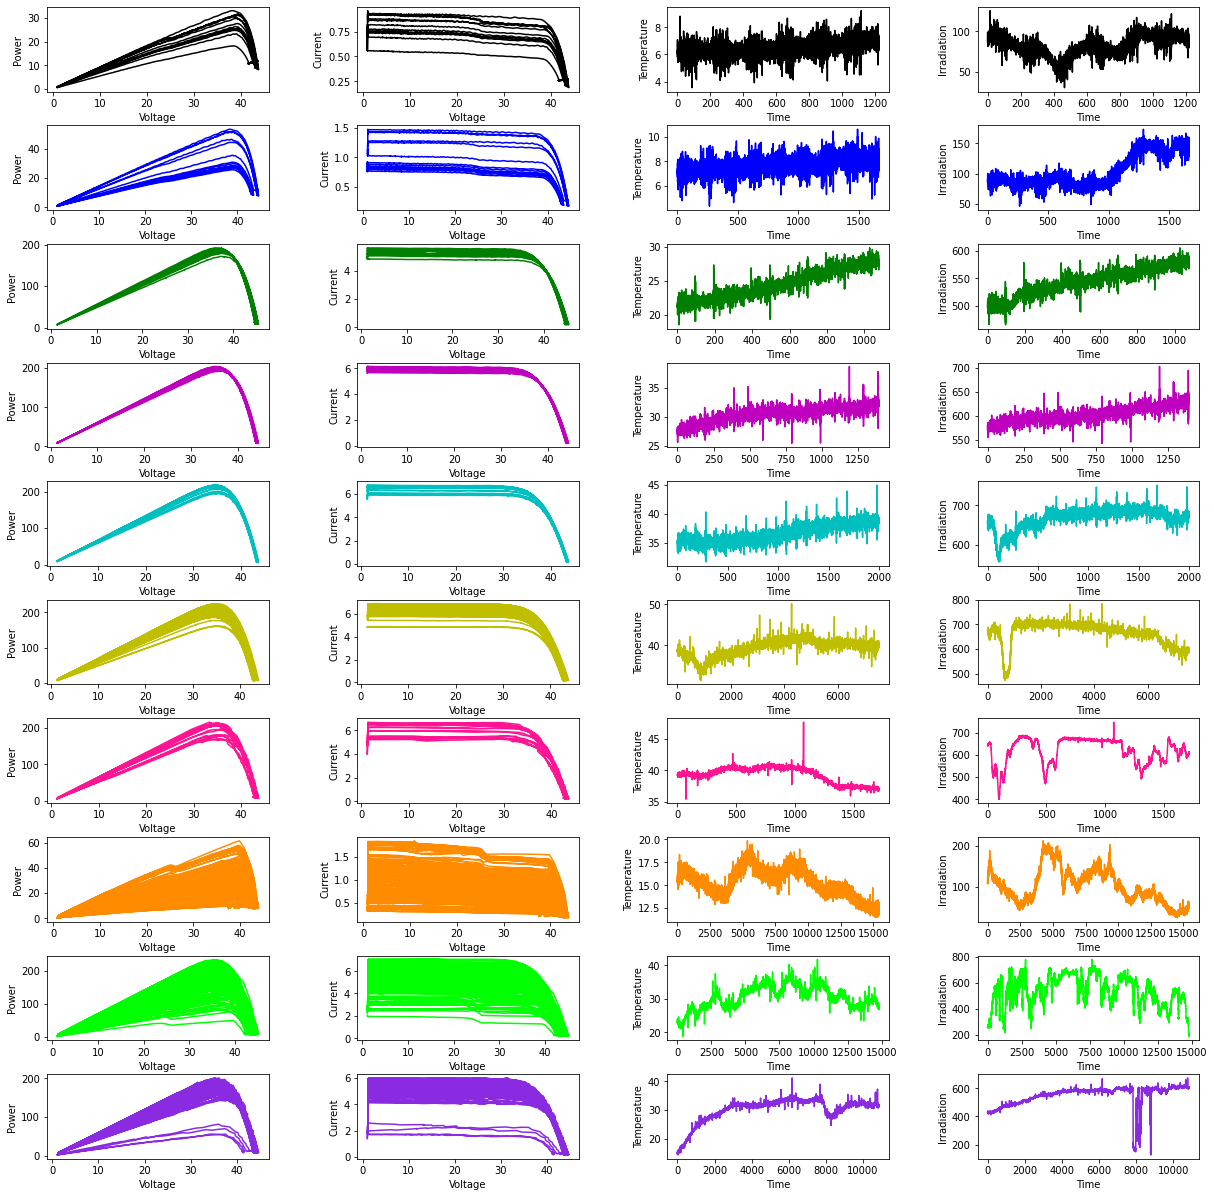

In [43]:
colors=['k','b','g','m','c','y','deeppink','darkorange','lime','blueviolet',]                
Xlab=['Voltage','Voltage','Time','Time']                                                # name of x-axis
Ylab=['Power','Current','Temperature','Irradiation']                                    # name of y-axis
nb_rows = 10  
nb_columns = 4  
plt_counter = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

data_frame=df


def subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig):
  itm=0
  color=0
  for i in range(nb_rows): 
    index=0 
    for j in range(nb_columns):
      plt.subplot(nb_rows, nb_columns, plt_counter)
      # plt.title('subplot: {} {} {}'.format( a, b, c))
      plt.xlabel(Xlab[index])
      plt.ylabel(Ylab[index])
      plt.plot(data_frame[X[itm]], data_frame[Y[itm]], colors[color]) #,label=k2[index]
      plt_counter = plt_counter + 1
      itm= itm + 1
      index=index+1
    color=color+1
  plt.show()

subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig)


## Filtring the Temperature and Irradiation signals

In [44]:
df_filtered=df

# Define the filter requirements
T = 1.0         # Sample Period
fs = 200.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples


# Filter implementation using scipy
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    F = filtfilt(b, a, data)
    return F


col=dfdf_filtered=df.columns
for i in range(0,len(col),6):
  data=df_filtered[col[i+1]]
  Filterd_temperature = butter_lowpass_filter(data, cutoff, fs, order)
  df_filtered[col[i+1]]=Filterd_temperature

  data=df_filtered[col[i+2]]
  Filterd_irradiation = butter_lowpass_filter(data, cutoff, fs, order)
  df_filtered[col[i+2]]=Filterd_irradiation



In [45]:
col=df_filtered.columns
X,Y= X_and_Y_axis(col)
print(X)
print(Y)

['V_PV01', 'V_PV01', 'TIME01', 'TIME01', 'V_PV02', 'V_PV02', 'TIME02', 'TIME02', 'V_PV03', 'V_PV03', 'TIME03', 'TIME03', 'V_PV04', 'V_PV04', 'TIME04', 'TIME04', 'V_PV05', 'V_PV05', 'TIME05', 'TIME05', 'V_PV06', 'V_PV06', 'TIME06', 'TIME06', 'V_PV07', 'V_PV07', 'TIME07', 'TIME07', 'V_PV08', 'V_PV08', 'TIME08', 'TIME08', 'V_PV09', 'V_PV09', 'TIME09', 'TIME09', 'V_PV10', 'V_PV10', 'TIME10', 'TIME10']
['P_PV01', 'I_PV01', 'T_PV01', 'G_PV01', 'P_PV02', 'I_PV02', 'T_PV02', 'G_PV02', 'P_PV03', 'I_PV03', 'T_PV03', 'G_PV03', 'P_PV04', 'I_PV04', 'T_PV04', 'G_PV04', 'P_PV05', 'I_PV05', 'T_PV05', 'G_PV05', 'P_PV06', 'I_PV06', 'T_PV06', 'G_PV06', 'P_PV07', 'I_PV07', 'T_PV07', 'G_PV07', 'P_PV08', 'I_PV08', 'T_PV08', 'G_PV08', 'P_PV09', 'I_PV09', 'T_PV09', 'G_PV09', 'P_PV10', 'I_PV10', 'T_PV10', 'G_PV10']


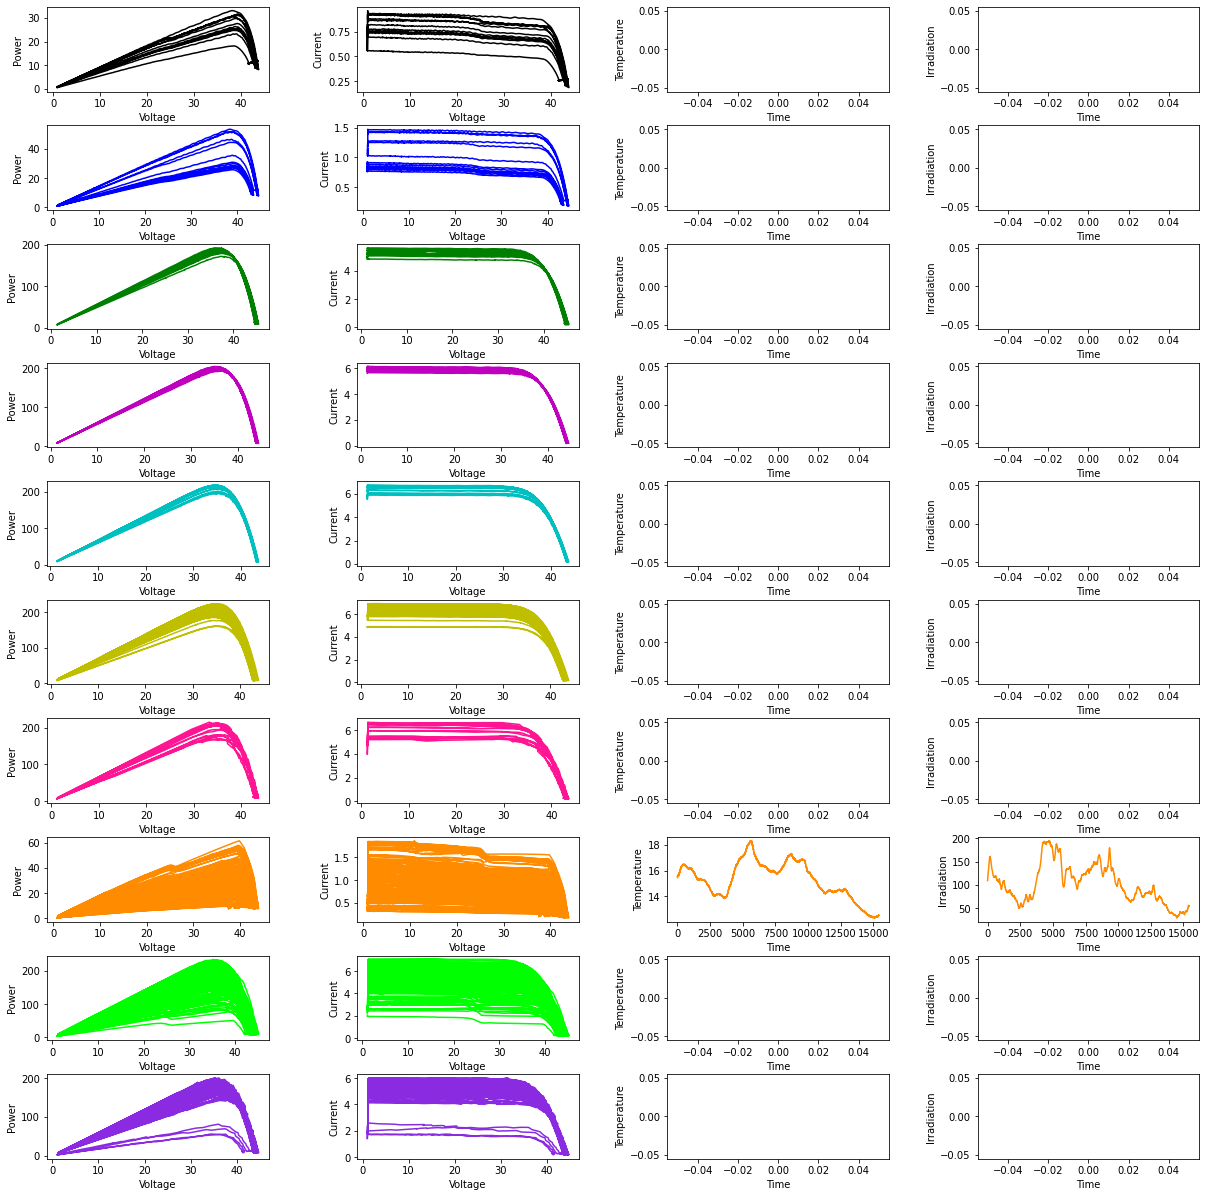

In [46]:
data_frame=df_filtered
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

subplot_data(data_frame,nb_rows,nb_columns,plt_counter,colors,X,Y,Xlab,Ylab,fig)

# Maximum power points

To claculate the maximum power pint for each curve, first we need to plot the power versus the time

In [53]:

# determination of x-axis and y-axis 
col=df.columns
Time=[]   
Temperature=[]
Irradiation=[]
Current=[]
Voltage=[]
Power=[]

Time_index=[]
Temperature_index=[]
Irradiation_index=[]
Current_index=[]
Voltage_index=[]
Power_index=[]

for i in range(0,len(col),6):
  index=col[i] 
  Time.append(index)
  Time_index.append(i)
  index=col[i+1] 
  Temperature.append(index)
  Temperature_index.append(i+1)
  index=col[i+2]
  Irradiation.append(index)
  Irradiation_index.append(i+2)
  index=col[i+3] 
  Current.append(index)
  Current_index.append(i+3)
  index=col[i+4] 
  Voltage.append(index)
  Voltage_index.append(i+4)
  index=col[i+5] 
  Power.append(index)
  Power_index.append(i+5)


# convert list to array
Time=np.array(Time)
Temperature=np.array(Temperature)
Irradiation=np.array(Irradiation)
Current=np.array(Current)
Voltage=np.array(Voltage)
Power=np.array(Power)

print(Time_index,'\n', Temperature_index,'\n',Irradiation_index,'\n',Current_index,'\n',Voltage_index,'\n',Power_index)
print(Time,'\n', Temperature,'\n',Irradiation,'\n',Current,'\n',Voltage,'\n',Power)

[0, 6, 12, 18, 24, 30, 36, 42, 48, 54] 
 [1, 7, 13, 19, 25, 31, 37, 43, 49, 55] 
 [2, 8, 14, 20, 26, 32, 38, 44, 50, 56] 
 [3, 9, 15, 21, 27, 33, 39, 45, 51, 57] 
 [4, 10, 16, 22, 28, 34, 40, 46, 52, 58] 
 [5, 11, 17, 23, 29, 35, 41, 47, 53, 59]
['TIME01' 'TIME02' 'TIME03' 'TIME04' 'TIME05' 'TIME06' 'TIME07' 'TIME08'
 'TIME09' 'TIME10'] 
 ['T_PV01' 'T_PV02' 'T_PV03' 'T_PV04' 'T_PV05' 'T_PV06' 'T_PV07' 'T_PV08'
 'T_PV09' 'T_PV10'] 
 ['G_PV01' 'G_PV02' 'G_PV03' 'G_PV04' 'G_PV05' 'G_PV06' 'G_PV07' 'G_PV08'
 'G_PV09' 'G_PV10'] 
 ['I_PV01' 'I_PV02' 'I_PV03' 'I_PV04' 'I_PV05' 'I_PV06' 'I_PV07' 'I_PV08'
 'I_PV09' 'I_PV10'] 
 ['V_PV01' 'V_PV02' 'V_PV03' 'V_PV04' 'V_PV05' 'V_PV06' 'V_PV07' 'V_PV08'
 'V_PV09' 'V_PV10'] 
 ['P_PV01' 'P_PV02' 'P_PV03' 'P_PV04' 'P_PV05' 'P_PV06' 'P_PV07' 'P_PV08'
 'P_PV09' 'P_PV10']


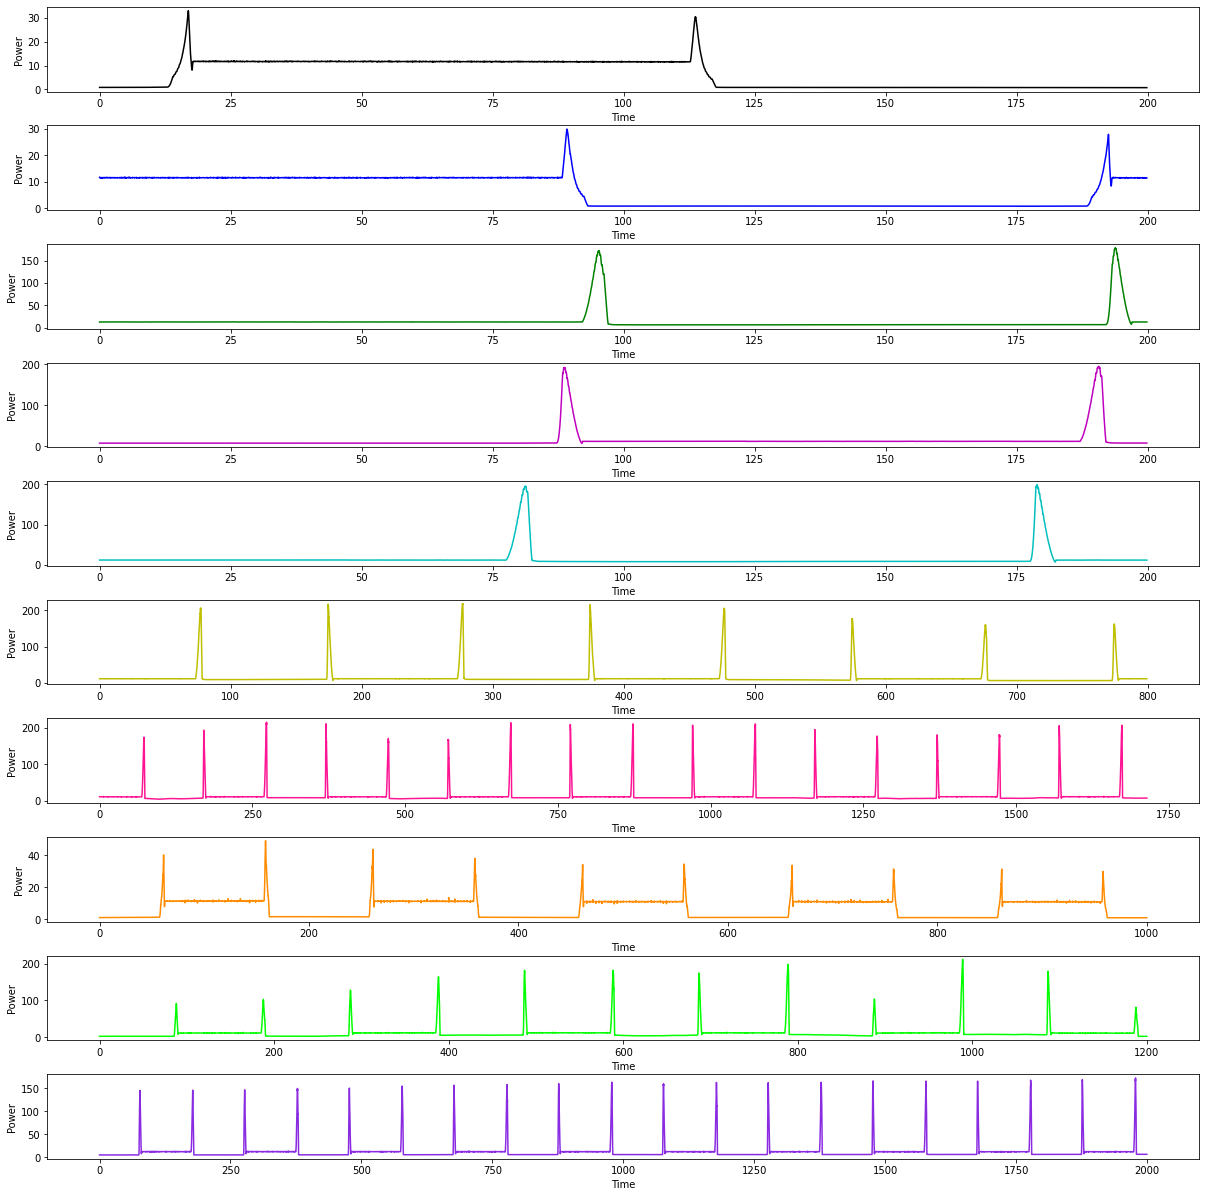

In [48]:
nb_rows = 10  
nb_columns = 1 
plt_counter = 1  # initialize plot counter

fig = plt.figure(figsize=(20,20))

# The following adjustment is needed to make space between the figures
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

df_limit=df[0:20000]

itm=0
for i in range(len(Time)): 
  plt.subplot(nb_rows, nb_columns, plt_counter)
  # plt.title('subplot: {} {} {}'.format( a, b, c))
  plt.xlabel('Time')
  plt.ylabel('Power')
  plt.plot(df_limit[Time[itm]], df_limit[Power[itm]], colors[itm]) #,label=k2[index]
  plt_counter = plt_counter + 1
  itm= itm + 1
plt.show()

We have ploted the Power Vs Time for the first 20 000 row in order to dtermine the periods used for recording. So according to the graph above, we can calculate the maximum power using the followin information:
- For the first 5 graphs we can calculate the maximum power for each 10.000 row.
- For the 6th graph we can calculate the maximum power for each 2.500 row.
- For the 7th and 10th graph we can calculate the maximum power for each 1000 row.
- For the 8th graph we can calculate the maximum power for each 2000 row.
- For the 9th graph we can calculate the maximum power for each 10.000/6 row.


In [145]:
# Replace NaN Values with Zeros
df = df.replace(np.nan, 0)
PMAX=[]
VMAX=[]
IMAX=[]
GMAX=[]
TMAX=[]
MAX_index=[]

cursor=0
for i in range(len(Power)):
  if cursor<5:
    step=10000
  if cursor==5:
    step=2500
  if cursor==6 or cursor==9:
    step=1000
  if cursor==7:
    step==2000
  if cursor==8:
    step=10000//6
  for j in range(0,len(df[Power[i]]),step):
    max_value=max(df.iloc[j:j+step,Power_index[cursor]])
    if max_value != 0:
      PMAX.append(max_value)
      max_index = df[df[Power[i]]==max_value].index.values.astype(int)[0]
      MAX_index.append(max_index)
      IMAX.append(df.iloc[max_index,Current_index[cursor]])
      VMAX.append(df.iloc[max_index,Voltage_index[cursor]])
      GMAX.append(df.iloc[max_index,Irradiation_index[cursor]])
      TMAX.append(df.iloc[max_index,Temperature_index[cursor]])
        # print(max_value,max_index)
  # if cursor
  cursor=cursor+1  
      

print(len(PMAX),'\n', type(PMAX))
print(PMAX,'\n', IMAX,'\n',VMAX,'\n',GMAX,'\n',TMAX,'\n',MAX_index)

736 
 <class 'list'>
[33.07633206, 30.44745098, 25.37856409, 26.3653998, 18.13863796, 23.26406719, 27.60753703, 25.55577635, 24.71185496, 31.6370149, 31.1843262, 31.46139347, 29.74214685, 29.80632042, 27.87802723, 26.82767487, 28.08107548, 28.53886639, 30.79193715, 28.14522076, 25.68262143, 27.68505238, 27.92600081, 35.54091909, 44.37332171, 51.35441566, 51.54134978, 46.45336249, 53.35517745, 12.46730693, 171.7600396, 178.7159692, 181.0285378, 182.7938259, 184.6409298, 186.0946512, 188.3809904, 188.969477, 190.5115262, 192.2631118, 12.71506222, 192.2823217, 194.7709757, 195.1876881, 194.8823849, 194.7748763, 195.1417434, 195.5175157, 196.7116268, 198.7622132, 198.8528237, 201.4907686, 201.3599448, 202.2144355, 203.973946, 194.6631797, 198.0441914, 201.1130015, 207.1366487, 208.3631948, 214.0895956, 216.2009263, 215.6842809, 215.997196, 216.9977781, 216.3594615, 216.0553322, 218.2985526, 217.8329407, 216.9104558, 217.702669, 216.5980001, 212.2570636, 212.8817431, 213.5072436, 206.345428

In [109]:
# Convert the lists of the maximum to Pandas Dataframe
[MAX_index, PMAX, VMAX, IMAX, GMAX, TMAX]
df = pd.DataFrame (products_list, columns = ['product_name', 'price'])
print (df)

In [19]:
# # In case the database is connected via the method 2, then the following error will apear when plotting the 3d graph: 
# # unsupported operand type(s) for *: 'float' and 'decimal.Decimal'. To solve this error, the following code can be used:
# for col in df_max.columns:
#   df_max[col]=np.array(df_max[col], dtype=float)

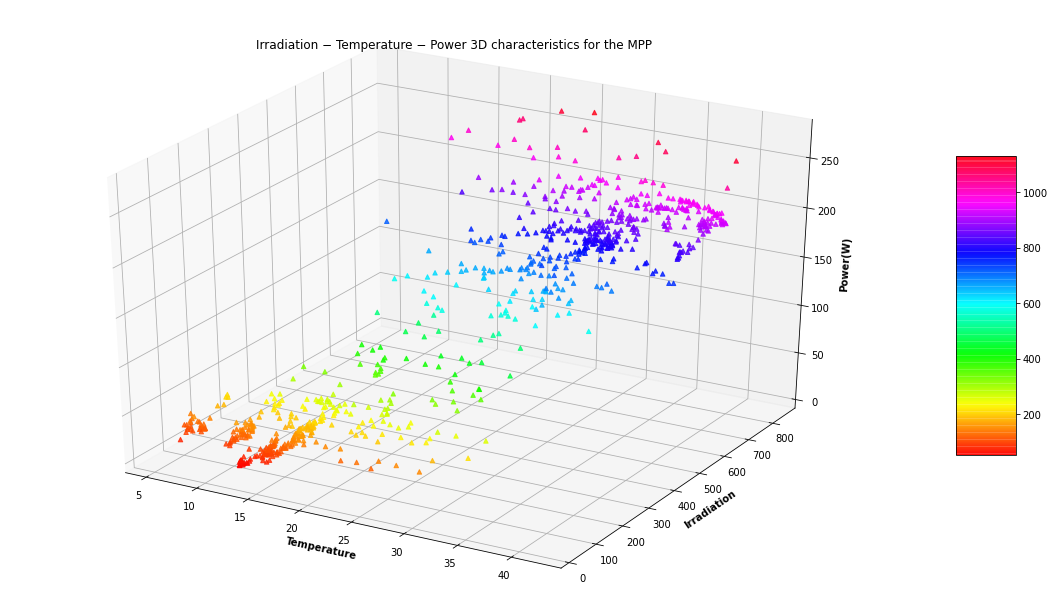

In [24]:
# Creating figure
fig = plt.figure(figsize = (20, 11))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
x=df_max['T']
y=df_max['G']
z=df_max['PMAX']

sctt = ax.scatter3D(x, y, z,
                    alpha = .8,
                    c = (x + y + z),
                    cmap = my_cmap,
                    marker ='^')
 
plt.title("Irradiation − Temperature − Power 3D characteristics for the MPP")
ax.set_xlabel('Temperature', fontweight ='bold')
ax.set_ylabel('Irradiation', fontweight ='bold')
ax.set_zlabel('Power(W)', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
 
plt.show()

##Loading data into a Spark DataFrame





In [ ]:
# Creating a spark context class
sc = SparkContext()

# Creating a spark session
spark = SparkSession \
    .builder \
    .appName("Python Spark DataFrames") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Initialize Spark session
spark

# We use the `createDataFrame` function to load the data into a spark dataframe
sdf = spark.createDataFrame(df0)

# Let us look at the schema of the loaded spark dataframe
sdf.printSchema()

In [ ]:
sdf_max = spark.createDataFrame(df_max)

sdf_max.printSchema()

##Converting data frame columns into feature vectors

In [ ]:
assembler1 = VectorAssembler(
    inputCols=["T", "G"],
    outputCol="features1")

assembler2 = VectorAssembler(
    inputCols=["T", "Pmax"],
    outputCol="features2")

assembler3 = VectorAssembler(
    inputCols=["G", "Pmax"],
    outputCol="features3")

# Output voltage
output1 = assembler1.transform(sdf1).select('features1','Vmax')
output2 = assembler2.transform(sdf1).select('features2','Vmax')
output3 = assembler3.transform(sdf1).select('features3','Vmax')

# Output Current
output4 = assembler1.transform(sdf1).select('features1','Imax')
output5 = assembler2.transform(sdf1).select('features2','Imax')
output6 = assembler3.transform(sdf1).select('features3','Imax')


train1, test1 = output1.randomSplit([0.75, 0.25])
train2, test2 = output2.randomSplit([0.75, 0.25])
train3, test3 = output3.randomSplit([0.75, 0.25])
train4, test4 = output4.randomSplit([0.75, 0.25])
train5, test5 = output5.randomSplit([0.75, 0.25])
train6, test6 = output6.randomSplit([0.75, 0.25])

#stats

##1) Correlation
 Correlation means to find out the association between the two variables and Correlation coefficients are used to find out how strong is the relationship between the two variables.

### a) *Pearson* correlation

In [ ]:
corr1 = Correlation.corr(train1, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='pearson').head()
print("Pearson correlation matrix:\n" + str(corr6[0]))

### b) *Spearman* correlation

In [ ]:

corr1 = Correlation.corr(train1, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr1[0]))

corr2 = Correlation.corr(train2, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr2[0]))

corr3 = Correlation.corr(train3, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr3[0]))

corr4 = Correlation.corr(train4, "features1", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr4[0]))

corr5 = Correlation.corr(train5, "features2", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr5[0]))

corr6 = Correlation.corr(train6, "features3", method='spearman').head()
print("Spearman correlation matrix:\n" + str(corr6[0]))


##2) Normalization

##3) Standardization

# Training

In [ ]:
#upload data from local machine

# uploaded = files.upload()  
# data= io.BytesIO(uploaded['PV_all_data.xlsx'])
# df = pd.read_excel(data)

# upload Excel data from git
# url = 'https://github.com/Mohamed-derbeli/ML-for-maximum-power-point-tracking-prediction-in-PV-system/blob/main/PV_data.xlsx?raw=true'





# 2D
# df.plot(x ='Vmax', y='Pmax', kind = 'scatter')	
# df.plot(x ='Vmax', y='Imax', kind = 'scatter')	

# 3D without color
# threedee = plt.figure(figsize = (12, 8)).gca(projection='3d')
# threedee.scatter(df['T'], df['G'], df['Pmax'])
# threedee.set_xlabel('Temperature')
# threedee.set_ylabel('Irradiation')
# threedee.set_zlabel('Power(W)')
# plt.show()

#converting spark dataframe to pandas dataframe aiming to use matplotlib
# pdf = sdf.toPandas()